<h1>Notebook: Autoencoder para Sistemas de Recomendación con MovieLens 1M</h1>

<h4>Configuración del Entorno<h4>

In [9]:
#Primero, importaremos las librerías necesarias y configuraremos el dispositivo (CPU o CUDA) para aprovechar la aceleración de hardware si está disponible.
# Importación de librerías necesarias
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

from models.sae import SAE
from utils.data_preprocessing import load_ratings, load_movies, binarize
from Recommender import get_user_ratings, recommend_movies_sae


# Configuración del dispositivo (CPU o CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")


Usando dispositivo: cuda


<h4>Carga y Preprocesamiento de los Datos<h4>

In [10]:
ratings = load_ratings('data/ml-1m/ratings.dat')
print("Valoraciones cargadas exitosamente.")


Valoraciones cargadas exitosamente.


In [12]:
# Obtener el número único de usuarios y películas
nb_users = ratings['UserID'].nunique()
nb_movies = ratings['MovieID'].nunique()
print(f"Número de usuarios: {nb_users}")
print(f"Número de películas: {nb_movies}")


Número de usuarios: 6040
Número de películas: 3706


In [13]:
# Mapear MovieIDs a índices consecutivos
#Para facilitar el manejo de las películas en matrices, mapearemos cada MovieID a un índice consecutivo.
unique_movie_ids = ratings['MovieID'].unique()
movie_id_to_index = {movie_id: index for index, movie_id in enumerate(unique_movie_ids)}
index_to_movie_id = {index: movie_id for movie_id, index in movie_id_to_index.items()}
print("MovieIDs mapeados a índices consecutivos.")

MovieIDs mapeados a índices consecutivos.


In [15]:
# Convertir los datos a una matriz de usuarios vs películas
data = ratings.copy()
data['UserID'] = data['UserID'] - 1  # Ajustar índices de usuarios para que comiencen en 0
data['MovieIndex'] = data['MovieID'].map(movie_id_to_index)
data = data.dropna(subset=['MovieIndex'])
data['MovieIndex'] = data['MovieIndex'].astype(int)

# Crear una matriz llena de ceros
user_movie_matrix = np.zeros((nb_users, nb_movies))

# Llenar la matriz con las valoraciones
for row in data.itertuples():
    user_movie_matrix[row.UserID, row.MovieIndex] = row.Rating

print("Matriz de usuarios vs películas creada.")

# Convertir a tensores
user_movie_tensor = torch.FloatTensor(user_movie_matrix)
print("Matriz convertida a tensor de PyTorch.")

Matriz de usuarios vs películas creada.
Matriz convertida a tensor de PyTorch.


In [16]:
# Crear división de entrenamiento y prueba (80% entrenamiento, 20% prueba)
train_set, test_set = train_test_split(user_movie_tensor, test_size=0.2, random_state=42)
train_set = train_set.to(device)
test_set = test_set.to(device)
print("Conjuntos de entrenamiento y prueba creados.")


Conjuntos de entrenamiento y prueba creados.


In [17]:
# Definir la arquitectura del SAE
sae = SAE(nb_movies=nb_movies, layers=[128, 64]).to(device)
print("Autoencoder SAE definido.")

# Definir la función de pérdida y el optimizador
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(sae.parameters(), lr=0.001, weight_decay=1e-5)
print("Función de pérdida y optimizador configurados.")



Autoencoder SAE definido.
Función de pérdida y optimizador configurados.


<h2>Entrenamiento del SAE con Mini-Batches</h2>

In [19]:

nb_epoch = 70
train_loss_per_epoch = []
test_loss_per_epoch = []

print("Inicio del entrenamiento del SAE...")

for epoch in range(1, nb_epoch + 1):
    sae.train()
    train_loss = 0
    s = 0.
    
    for batch in train_loader:
        input = batch[0].to(device)
        target = input.clone()
        
        # Crear máscara para ignorar las películas no valoradas
        mask = target > 0
        
        # Forward pass
        output = sae(input)
        
        # Calcular la pérdida solo en las películas valoradas
        loss = criterion(output[mask], target[mask])
        
        # Backward pass y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        s += 1.
    
    average_train_loss = train_loss / s if s > 0 else 0
    train_loss_per_epoch.append(average_train_loss)
    
    # Evaluación en el conjunto de prueba
    sae.eval()
    test_loss = 0
    s_test = 0.
    with torch.no_grad():
        for batch in test_loader:
            input = batch[0].to(device)
            target = input.clone()
            mask = target > 0
            output = sae(input)
            loss = criterion(output[mask], target[mask])
            test_loss += loss.item()
            s_test += 1.
    
    average_test_loss = test_loss / s_test if s_test > 0 else 0
    test_loss_per_epoch.append(average_test_loss)
    
    print(f"Época: {epoch}, Pérdida de Entrenamiento: {average_train_loss:.4f}, Pérdida de Prueba: {average_test_loss:.4f}")

print("Entrenamiento completado.")


Inicio del entrenamiento del SAE...
Época: 1, Pérdida de Entrenamiento: 7.9192, Pérdida de Prueba: 4.1443
Época: 2, Pérdida de Entrenamiento: 3.4409, Pérdida de Prueba: 2.9737
Época: 3, Pérdida de Entrenamiento: 2.5390, Pérdida de Prueba: 2.4249
Época: 4, Pérdida de Entrenamiento: 2.1444, Pérdida de Prueba: 2.4774
Época: 5, Pérdida de Entrenamiento: 1.9706, Pérdida de Prueba: 2.2471
Época: 6, Pérdida de Entrenamiento: 1.8509, Pérdida de Prueba: 1.8447
Época: 7, Pérdida de Entrenamiento: 1.7376, Pérdida de Prueba: 2.0815
Época: 8, Pérdida de Entrenamiento: 1.5046, Pérdida de Prueba: 2.0633
Época: 9, Pérdida de Entrenamiento: 1.4174, Pérdida de Prueba: 1.9069
Época: 10, Pérdida de Entrenamiento: 1.4298, Pérdida de Prueba: 1.8351
Época: 11, Pérdida de Entrenamiento: 1.3140, Pérdida de Prueba: 1.8836
Época: 12, Pérdida de Entrenamiento: 1.2451, Pérdida de Prueba: 1.6426
Época: 13, Pérdida de Entrenamiento: 1.2022, Pérdida de Prueba: 1.4338
Época: 14, Pérdida de Entrenamiento: 1.1112, Pérdi

<h2>Visualización de la Pérdida</h2>

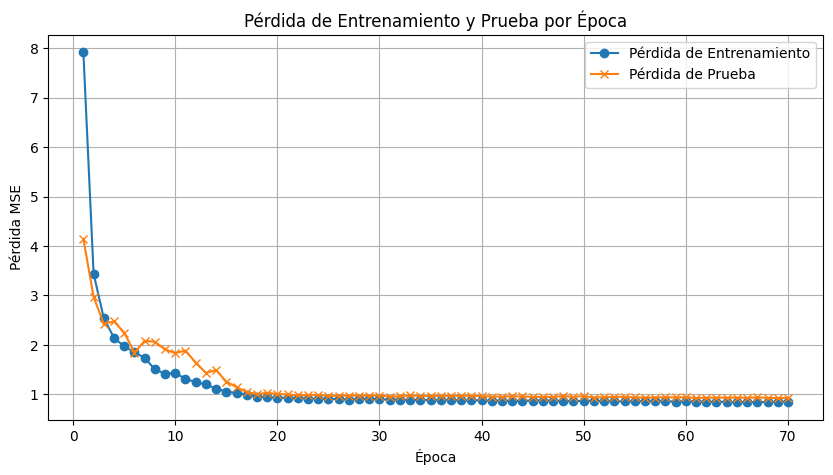

Gráfico de pérdida generado y guardado.


In [20]:
plt.figure(figsize=(10,5))
plt.plot(range(1, nb_epoch + 1), train_loss_per_epoch, marker='o', label='Pérdida de Entrenamiento')
plt.plot(range(1, nb_epoch + 1), test_loss_per_epoch, marker='x', label='Pérdida de Prueba')
plt.xlabel('Época')
plt.ylabel('Pérdida MSE')
plt.title('Pérdida de Entrenamiento y Prueba por Época')
plt.legend()
plt.grid(True)
plt.show()
print("Gráfico de pérdida generado y guardado.")

